## Exercise 1: SIR model

[The SIR model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) is a simple mathematical model to simulate epidemics. In this model, the population is divided into three groups: **S**usceptible, **I**nfectious, and **R**emoved (recovered or dead). The size of the respective groups is given as functions of time $S(t)$, $I(t)$ and $R(t)$. It is also assumed that there is an infection rate $\beta\in\mathbb{R}_{+}$ and a recovery/death rate $\gamma\in\mathbb{R}_{+}$. Then the model is defined by the following system of differential equations:

$$\dfrac{dS}{dt} = -\beta I S, \quad \dfrac{dI}{dt} = \beta I S - \gamma I, \quad \dfrac{dR}{dt} = \gamma I$$

**a)** Solve the system of equations with initial conditions $S(0)=0.997$, $I(0)=0.03$, $R(0)=0$, and parameters $\beta=0.4$, $\gamma=0.04$, using ```scipy.integrate.solve_ivp``` function. Plot $S, I$ an $R$ over the time interval $t\in[0,100]$.

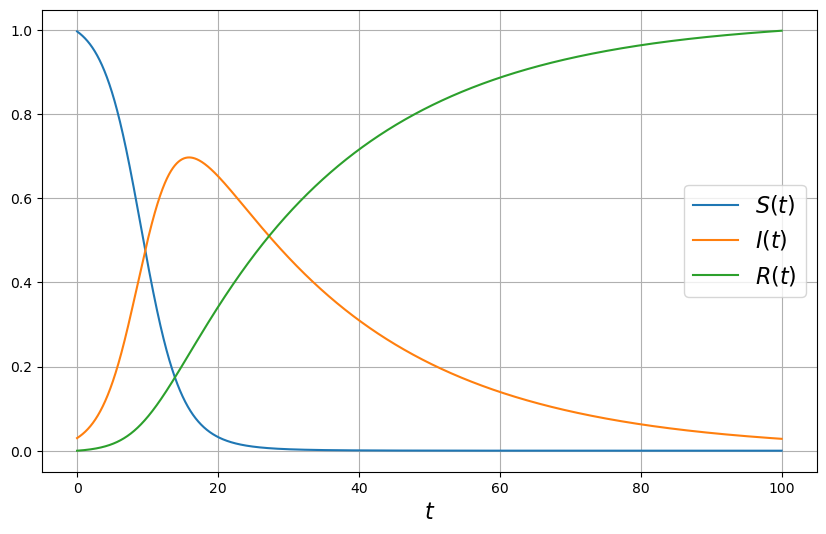

In [2]:
import numpy as np
from scipy import integrate
from scipy import linalg
from matplotlib import pyplot as plt


# We need to define the right hand side of the system as a function fun(t,y,args) to use scipy.integrate.solve_ivp function
# Here t is a scalar time and y is the vector of the system state.
# In our case, y has shape (3,) and contains variables S,I,R.
# (see documentation of scipy.integrate.solve_ivp)
def sir(t,y,beta,gamma):
    s,i,r=y
    return [-beta*s*i, beta*s*i-gamma*i, gamma*i]

# Set the initial conditions and the parameters
s_0, i_0, r_0, beta, gamma = 0.997, 0.03, 0, 0.4, 0.04

# Solve the ODE
sol = integrate.solve_ivp(sir, [0,100],[s_0,i_0,r_0],
                          t_eval=np.linspace(0,100,10000), args=(beta,gamma))

# Plot the results
fig, ax = plt.subplots(figsize=(10,6))

# Matrix sol.y contains solutions for all the 3 variables S,R,I as rows 0,1,2
plt.plot(sol.t, sol.y[0], label = '$S(t)$')
plt.plot(sol.t, sol.y[1], label = '$I(t)$')
plt.plot(sol.t, sol.y[2], label = '$R(t)$')

plt.xlabel('$t$', fontsize=16)

plt.legend(fontsize=16)
plt.grid()

**b)** Determine the moment when the fraction of infectious individuals reaches its maximum and mark this point in the plot. 


The maximal fraction of infectios individuals is 0.70, and is achieved at time t=15.90.


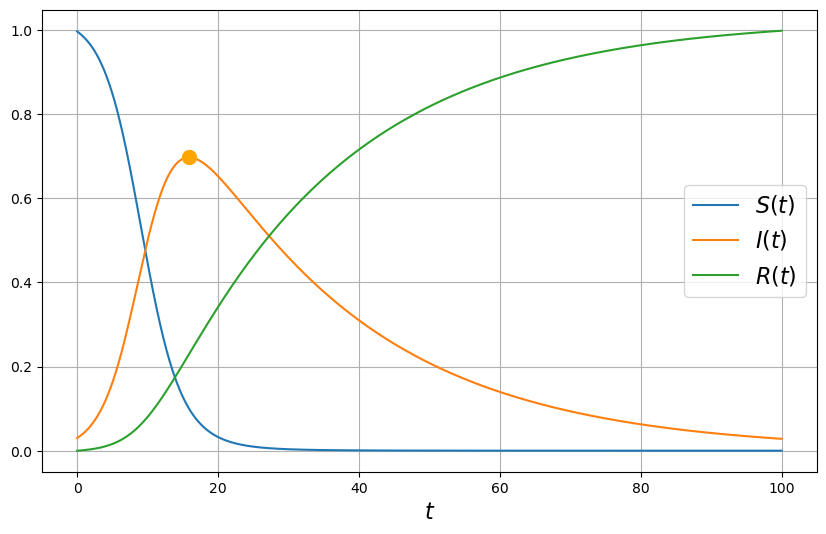

In [3]:
# There are many ways to find the maximum of I(t)
# First option: use numpy.argmax 

t_max = np.argmax(sol.y[1])
print(f"The maximal fraction of infectios individuals is {sol.y[1,t_max]:0.2f}, and is achieved at time t={sol.t[t_max]:0.2f}.")

# We can now add this point to the figure
fig, ax = plt.subplots(figsize=(10,6))

# Plot solution curves for S,R,I variables
plt.plot(sol.t, sol.y[0], label = '$S(t)$')
plt.plot(sol.t, sol.y[1], label = '$I(t)$')
plt.plot(sol.t, sol.y[2], label = '$R(t)$')

# Mark the maximum of S(t) as a point on the plot
plt.plot(sol.t[t_max],sol.y[1,t_max],'o', color='orange', markersize=10)

plt.xlabel('$t$', fontsize=16)

plt.legend(fontsize=16)
plt.grid()

In [4]:
# Alternatively, we can find the maximum by defining an event to be tracked by scipy.integrate.solve_ivp (see documentation).
# An event should be defined as a function that reaches 0 iff the event of interest happens. 
# Since we are looking for a maximum of I(t), our event of interest can be the moment when the derivative of I(t) reaches zero.
def event_max(t,y,beta,gamma):
    return sir(t,y,beta,gamma)[1]

# We now solve the ODE again with argument events = event_max
sol = integrate.solve_ivp(sir, [0,100],[s_0,i_0,r_0], 
                          t_eval=np.linspace(0,100,10000), args=(beta,gamma), events = event_max)

# Now the events are returned as sol.t_events, sol.y_events
print(f"The maximal number of infectios people is {sol.y_events[0][0][1]:0.2f} and is achieved at time t={sol.t_events[0][0]:0.2f}.")

The maximal number of infectios people is 0.70 and is achieved at time t=15.89.


In [5]:
# The maximum can also be determined theoretically (see e.g. wikipedia on SIR model)
rho = gamma/beta
print(f"The theoretical solution: {1-rho+rho*np.log(rho/s_0)}.")

The theoretical solution: 0.6700419416026253.


**c)**$^*$ Determine the maximal infection rate $\beta'$ such that for $\gamma=0.04$ and all $\beta\leq\beta'$ the epidemic does not break out, i.e. $I(t) < I(0)$ for any $t>0$. To do so, you can use *binary search* algorithm, described below:

1. Start with a reasonable interval $[l,r]$ for $\beta'$, e.g, $[0,0.4]$.
2. Check whether the infection is still breaking out in the center of the interval $m=(l+r)/2$ or not.
3. If the infection still breaks out, then $\beta' < m$ and we can restrict the interval to $[l,m]$. If the infection no longer breaks out, then $\beta' > m$ and we restrict the interval to $[m,r]$.
4. Repeat this procedure with the new interval until the desired accuracy is achieved (each step reduces the error by factor $1/2$).


In [7]:
# We use binary search to find the maximal infection rate beta'

beta_upper = 0.4
beta_lower = 0
eps = 10**-8

while beta_upper-beta_lower > eps:
    # define the middle point
    beta=(beta_lower+beta_upper)/2
    # Solve the ODE with beta = (beta_lower+beta_upper)/2
    sol = integrate.solve_ivp(sir, [0,100], [s_0,i_0,r_0], args=(beta,gamma))
    # If the infection breaks out, the end value is greater than the starting value
    # If this is not the case, the infection does not break out
    if np.all(sol.y[1]<=sol.y[1][0]):
        beta_lower = beta
    else:
        beta_upper = beta

        
print(f"The maximal infection rate such that the epidemic does not break out: {beta_upper}")

# We can compare with the theoretical solution (see e.g. wiki on SIR model)
print(f"The theoretical solution: {gamma/s_0}")

The maximal infection rate such that the epidemic does not break out: 0.040122961997985845
The theoretical solution: 0.04012036108324975


## Exercise 2: Planetary orbits (II)

In exercise 2 of week 8, we computed possible orbits of Earth around the Sun with varying initial conditions. Our method to compute the orbits in that exercise was, in fact, an implementation of a very simple approach to numerical integration called [the Euler method](https://en.wikipedia.org/wiki/Euler_method). The Euler method is the simplest method of the class of [Runge–Kutta methods](https://en.wikipedia.org/wiki/Runge–Kutta_methods) for iterative numerical integration. As you can see in the documentation, the function ```scipy.integrate.solve_ivp``` uses Runge–Kutta methods of higher order to perform numerical integration with higher precision and much faster than we did in our naive implementation.

In this task, we will use ```scipy.integrate.solve_ivp``` to compute the Earth's orbits again. To do so, we can reformulate the ODEs governing Earth's movement as a following system of first-order equations:

$$\dot x_1 = v_1, \quad \dot x_2 = v_2, \quad \dot v_1 = -Gm^{star}\dfrac{x_1}{(x_1^2+x_2^2)^{3/2}}, \quad \dot v_2 = -Gm^{star}\dfrac{x_2}{(x_1^2+x_2^2)^{3/2}}.$$

Here $x=(x_1,x_2)$ is the position of Earth, and $v=(v_1,v_2)$ is the velocity of Earth. As before, we can set the initial conditions to $x(0) = (0,1)$ and $v(0)=(c\cdot 2\pi,0)$, where we can vary the constant $c$ to change the shape of the orbit.

**a)** Solve the ODE for a range of values of $c$ and plot the resulting orbits. You should obtain a plot identical to the one from exercise 2, week 8. Note that using the default parameters of ```scipy.integrate.solve_ivp``` in this task can lead to large accumulated computational error, so your orbits may not have a coorect shape in this case. To increase precision of your calculations, you can use the argument ```method='DOP853'``` of ```scipy.integrate.solve_ivp``` function to use Runge-Kutta method of order 8 for the numerical integration. Alternatively, you can decrease the parameter ```max_step``` (maximal time step in numerical integration) to bound the computational error. 

Text(0, 0.5, 'y')

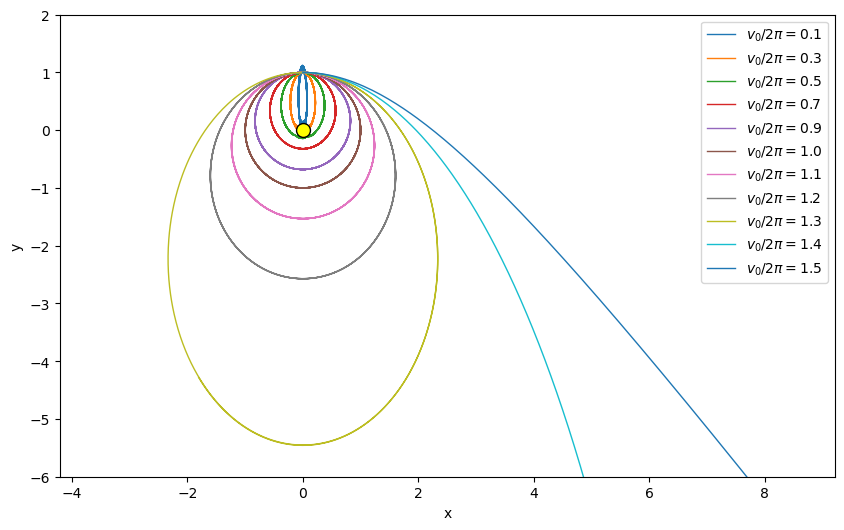

In [8]:
fig, ax = plt.subplots(figsize=(10,6))

# Define the system ad fun(t,y,args) to use scipy.integrate.solve_ivp function
def orbit(t,y,G,M):
    x1,x2,v1,v2=y
    x_norm = np.linalg.norm(np.array([x1,x2]))
    return [v1, v2, -G*M*x1/(x_norm**3), -G*M*x2/(x_norm**3)]

# Set the parameters
G, M =  4.*(np.pi**2), 1.
x1, x2 = [0., 1.]

c_vals = [0.1,0.3,0.5,0.7,0.9,1.0,1.1,1.2,1.3,1.4,1.5]

for c in c_vals:
    v1, v2 = [c*2.*np.pi, 0.]

    # Solve the ODE 
    sol = integrate.solve_ivp(orbit, [0,10],[x1, x2, v1, v2],
                            t_eval=np.linspace(0,10,1000), args=(G,M), method='DOP853')
    
    # Plot the results
    plt.plot(sol.y[0], sol.y[1], label=f"$v_0/2\pi=${c}", linewidth=1)


plt.plot([0], [0], marker='o', color='yellow', markeredgecolor='black', markersize=10) 
plt.legend()

plt.axis("equal") # make axis aspect ratios equal (otherwise circular orbits would look elliptic)
plt.xlim([-2,7])
plt.ylim([-6,2])

plt.xlabel('x')
plt.ylabel('y')

**b)** The velocity norm of Earth traveling along an elliptic orbit can be computed using the following formula with a certain constant C:

$$\|v\| = C\cdot\sqrt{\Bigl(\dfrac{2}{\|x\|} - \dfrac{1}{a}\Bigr)},$$

where $a$ is the *length of the semi-major axis* of the ellipse, i.e., $2a$ is the longest diameter of the ellipse. The objective of this task is to determine the value of the constant $C$. To do so, you can follow these steps:

1. Calculate an orbit as in exercise (a) using initial conditions that result in an elliptic orbit.
2. Use the solution to calculate parameter $a$.
3. Create a dataset of the form $Y=\Bigl[ \|v(0)\|, \dots, \|v(T)\| \Bigr]$ (velocity norms at different time steps), $X=\Bigl[ \bigl[\sqrt{{2}/{\|x(0)\|} - {1}/{a}}\bigr], \dots,\bigl[\sqrt{{2}/{\|x(T)\|} - {1}/{a}}\bigr] \Bigr]$. I.e., $Y$ contains the left-hand-side of the equation above, and $X$ contains the right-hand-side without the constant $C$. 
4. Use the least squares method (```np.linalg.lstsq```) to determine the value of C based on data $(X,Y)$ (i.e., you should use least squares to determine the best parameter $C$ for equation $Y=C\cdot X$).

Can you guess what is the meaning of the parameter $C$ here from the determined value?

In [9]:
G, M =  4.*(np.pi**2), 1.

x1, x2 = [0., 1.]
v1, v2 = [1.3*2.*np.pi, 0.]

# Solve the ODE
sol = integrate.solve_ivp(orbit, [0,10],[x1, x2, v1, v2],
                        t_eval=np.linspace(0,10,10000), args=(G,M), method='DOP853')


# Calculate the sizes of the two axes of the ellipse
# as half of the difference between maximal and minimal x,y coordinates 
ax1 = (np.max(sol.y[0]) - np.min(sol.y[0]))/2.
ax2 = (np.max(sol.y[1]) - np.min(sol.y[1]))/2.

a = max(ax1,ax2) # major axis is the maximal one

X = np.sqrt(2./np.linalg.norm(sol.y.T[:,0:2], axis=1) - 1./a).reshape(-1,1) # RHS
Y = np.linalg.norm(sol.y.T[:,2:4], axis=1) # LHS

# Determine the parameter C using least squares method
C = linalg.lstsq(X, Y)[0].item()

print(f"The parameter C is equal to {C}.")

print(f"One can see that C is equal to 2*pi=sqrt(G) where G is the gravitational constant in astronomical units.")

The parameter C is equal to 6.2815405410923555.
One can see that C is equal to 2*pi=sqrt(G) where G is the gravitational constant in astronomical units.


---

<center><font size=5> Merry Christmas and Happy New Year! </font></center> 
    
<center><font size=5> See you after the holidays. </font></center> 